In [5]:
!pip install kaggle  # Step 1: Ensure Kaggle API is installed
!pip install opendatasets
!pip install natsort
!pip install kaggle opendatasets natsort matplotlib opencv-python tensorflow pillow

2025-08-15 01:20:59.669028: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-15 01:20:59.855753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755220859.930289    1202 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755220859.949165    1202 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755220860.104021    1202 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Skipping, found downloaded files in "./Data/ddti-thyroid-ultrasound-images" (use force=True to force download)
Data downloaded to ./Data
Preparing data from: ./Data/ddti-thyroid-ultrasound-images
Constructed DataFrame with 349 entries
Built image matrix of shape (349, 256, 256, 1)


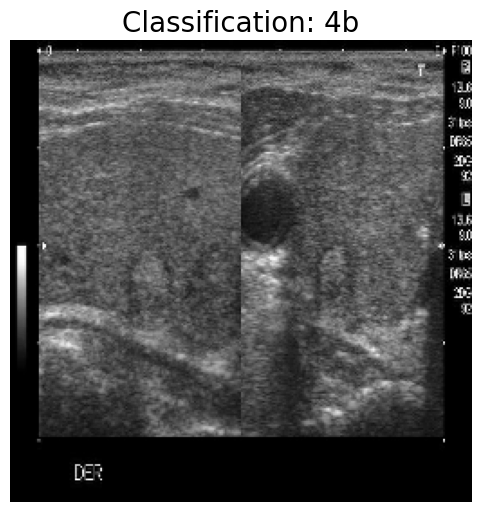

In [6]:
# ======================
# Step 1: Imports
# ======================
import os
import xml.etree.ElementTree as ET
from natsort import natsorted
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
from io import BytesIO
import opendatasets as od

# ======================
# Step 2: Download Kaggle dataset
# ======================
def download_kaggle_dataset(kaggle_url, target_dir='./Data'):
    print(f"Downloading from Kaggle: {kaggle_url}")
    od.download(kaggle_url, data_dir=target_dir)
    print(f"Data downloaded to {target_dir}")
    base_dir = os.path.join(target_dir, os.listdir(target_dir)[0])
    return base_dir

# ======================
# Step 3: Parse XML + Build DataFrame
# ======================
def to_dataframe(path):
    files = natsorted(os.listdir(path))
    xml_files = [f for f in files if f.lower().endswith('.xml')]
    img_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    records = []
    for xml in xml_files:
        xml_path = os.path.join(path, xml)
        tree = ET.parse(xml_path)
        elems = tree.findall(".//tirads")
        if elems and elems[-1].text:
            tirads_val = elems[-1].text.strip()
            base = xml[:-4]
            for img in img_files:
                if img.startswith(base + '_') and img.lower().endswith('.jpg'):
                    records.append([img, tirads_val])

    df = pd.DataFrame(records, columns=['Jpeg_Name', 'Tirads'])
    print(f"Constructed DataFrame with {len(df)} entries")
    return df

# ======================
# Step 4: Crop & Resize Helpers
# ======================
def crop_channel_or_full(img, x, y, w, h):
    if w > 2:
        return img[:, :, 0] if img.ndim == 3 else img
    return img

def crop_resize(img_path, resize_shape):
    img = plt.imread(img_path)
    img = np.asarray(img)
    if img.ndim == 3:
        img = img[..., 0]

    thresh = (img > 0).astype(np.uint8) * 255
    kernel = np.ones((5, 5), dtype=np.uint8)
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
    eroded = cv2.erode(opened, kernel, iterations=5)

    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cv2.resize(img, resize_shape, interpolation=cv2.INTER_LANCZOS4)

    areas = [cv2.contourArea(c) for c in contours]
    cnt = contours[np.argmax(areas)]
    x, y, w, h = cv2.boundingRect(cnt)

    roi = crop_channel_or_full(img, x, y, w, h)
    return cv2.resize(roi, resize_shape, interpolation=cv2.INTER_LANCZOS4)

# ======================
# Step 5: Build Image Matrix
# ======================
def to_imgmatrix(resize_shape, path, df):
    images = []
    for fname in df['Jpeg_Name']:
        img = crop_resize(os.path.join(path, fname), resize_shape)
        images.append(img[..., np.newaxis])
    images = np.stack(images, axis=0).astype(np.float32)
    print(f"Built image matrix of shape {images.shape}")
    return images

# ======================
# Step 6: Full Data Prep Pipeline
# ======================
def prepare_data(path, resize_shape=(256, 256)):
    print(f"Preparing data from: {path}")
    df = to_dataframe(path)
    images = to_imgmatrix(resize_shape, path, df)
    return df, images

# ======================
# Step 7: Convert TIRADS to categorical
# ======================
def to_categoricalmatrix(df):
    mapping = {
        '2': 0, '3': 1, '4a': 2, '4b': 3, '4c': 4, '5': 5
    }
    y = df['Tirads'].map(mapping).fillna(-1).astype(int)
    if (y < 0).any():
        print("Warning: Some TIRADS categories are unknown and marked as -1")
    return y.to_numpy()

# ======================
# Step 8: Normalize
# ======================
def normalize(data):
    return np.array([im / im.max() if im.max() > 0 else im for im in data], dtype=np.float32)

# ======================
# Step 9: Example Run
# ======================
if __name__ == "__main__":
    kaggle_url = "https://www.kaggle.com/datasets/dasmehdixtr/ddti-thyroid-ultrasound-images"
    data_dir = download_kaggle_dataset(kaggle_url, target_dir='./Data')
    df, imgs = prepare_data(data_dir, (256, 256))
    y_int = to_categoricalmatrix(df)
    y = tf.keras.utils.to_categorical(y_int, num_classes=6)
    y = y.astype(np.float32)
    x = normalize(imgs)

    idx = random.randint(0, len(df) - 1)
    plt.figure(figsize=(6, 6))
    plt.title(f"Classification: {df['Tirads'].iloc[idx]}", fontsize=20)
    plt.imshow(x[idx, ..., 0], cmap='gray')
    plt.axis('off')
    plt.show()


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import collections
import math
import string

# Assume you have your data ready:
# x shape: (349, 256, 256, 1)
# y shape: (349, 6) one-hot labels

# --- Dataset split ---
x_train = x[:300]
y_train = y[:300]

x_valid = x[300:313]
y_valid = y[300:313]

x_test = x[313:]
y_test = y[313:]

# --- Data augmentation on training data only ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(height_factor=(-0.2, 0.2), fill_mode="constant"),
    layers.RandomRotation(factor=(-0.2, 0.2), fill_mode="constant"),
    layers.RandomContrast(0.1)
])

x_train_aug = data_augmentation(x_train)
y_train_aug = np.copy(y_train)

for _ in range(20):
    x_aug = data_augmentation(x_train)
    x_train_aug = np.concatenate([x_train_aug, x_aug], axis=0)
    y_train_aug = np.concatenate([y_train_aug, y_train], axis=0)

# --- EfficientNetB0 model implementation ---

CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        'distribution': 'normal'
    }
}

BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'
])
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

def mb_conv_block(inputs, block_args, drop_rate):
    kernel_size = block_args.kernel_size
    input_filters = block_args.input_filters
    output_filters = block_args.output_filters
    expand_ratio = block_args.expand_ratio
    id_skip = block_args.id_skip
    strides = block_args.strides
    se_ratio = block_args.se_ratio

    expanded_filters = input_filters * expand_ratio
    x = layers.Conv2D(expanded_filters, (1, 1), padding="same", use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER)(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)

    # Remove kernel_initializer here:
    x_depth = layers.DepthwiseConv2D(kernel_size, padding="same", strides=strides, use_bias=False)(x)
    x = layers.BatchNormalization()(x_depth)
    x = tf.keras.activations.swish(x)

    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Reshape((1,1,expanded_filters))(se)
    squeezed_filters = max(1, int(input_filters * se_ratio))
    se = layers.Conv2D(squeezed_filters, (1,1), padding="same",
                       kernel_initializer=CONV_KERNEL_INITIALIZER)(se)
    se = tf.keras.activations.swish(se)
    se = layers.Conv2D(expanded_filters, (1,1), padding="same",
                       kernel_initializer=CONV_KERNEL_INITIALIZER)(se)
    se = tf.keras.activations.sigmoid(se)
    x = layers.Multiply()([x_depth, se])

    x = layers.Conv2D(output_filters, (1,1), padding="same", use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(drop_rate)(x)

    if id_skip and all(s == 1 for s in strides) and input_filters == output_filters:
        x = layers.Add()([inputs, x])
    return x

def round_filters(filters, width_coefficient, depth_divisor):
    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

def round_repeats(repeats, depth_coefficient):
    return int(math.ceil(depth_coefficient * repeats))

def EfficientNet(width_coefficient, depth_coefficient, default_resolution, dropout_rate=0.2,
                 drop_connect_rate=0.2, depth_divisor=8, model_name='efficientnet',
                 input_shape=None, blocks_args=DEFAULT_BLOCKS_ARGS, **kwargs):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2, 2), padding='same', use_bias=False,
                      name='stem_conv', kernel_initializer=CONV_KERNEL_INITIALIZER)(inputs)
    x = layers.BatchNormalization(name='stem_bn')(x)
    x = tf.keras.activations.swish(x)

    num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
    block_num = 0

    for idx, block_args in enumerate(blocks_args):
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters, width_coefficient, depth_divisor),
            output_filters=round_filters(block_args.output_filters, width_coefficient, depth_divisor),
            num_repeat=round_repeats(block_args.num_repeat, depth_coefficient)
        )

        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x = mb_conv_block(x, block_args, drop_rate)
        block_num += 1

        if block_args.num_repeat > 1:
            block_args = block_args._replace(input_filters=block_args.output_filters, strides=(1,1))
            for _ in range(block_args.num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                x = mb_conv_block(x, block_args, drop_rate)
                block_num += 1

    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same', use_bias=False, name='top_conv',
                      kernel_initializer=CONV_KERNEL_INITIALIZER)(x)
    x = layers.BatchNormalization(name='top_bn')(x)
    x = tf.keras.activations.swish(x)

    return tf.keras.Model(inputs, x, name=model_name)

def EfficientNetB0(input_shape):
    return EfficientNet(1.0, 1.0, 224, 0.2,
                       model_name='efficientnet-b0',
                       input_shape=input_shape)

# --- Build the model with EfficientNetB0 base ---

base_model = EfficientNetB0(input_shape=(256,256,1))

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation="relu", kernel_regularizer=regularizers.l1_l2(0.00001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model.summary()


2025-08-15 01:21:04.157662: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        288 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu (Silu)         │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,024 │ silu[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu_1 (Silu)       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 128, 128,  │        288 │ silu_1[0][0]      │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu_2 (Silu)       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ silu_2[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 1, 8)   │        264 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu_3 (Silu)       │ (None, 1, 1, 8)   │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 1, 32)  │        288 │ silu_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid (Sigmoid)   │ (None, 1, 1, 32)  │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128,  │          0 │ depthwise_conv2d… │
│                     │ 32)               │            │ sigmoid[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        512 │ multiply[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,417,634 (24.48 MB)

 Trainable params: 6,375,554 (24.32 MB)

 Non-trainable params: 42,080 (164.38 KB)

In [8]:
# Define AUC metric (ROC curve) for multiclass
metrics = tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    multi_label=True  # This is important for multi-class AUC
)

# Compile model with Adam optimizer, categorical crossentropy loss, and AUC metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=[metrics]
)

# Learning rate scheduler callback function
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 15
    if epoch != 0 and epoch % decay_step == 0:
        return lr * decay_rate
    return lr

lr_call = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

epochs = 10

# Train the model with augmented data
history = model.fit(
    x_train_aug,  # augmented training images
    y_train_aug,  # augmented training labels
    batch_size=64,
    epochs=epochs,
    callbacks=[lr_call],
    validation_data=(x_valid, y_valid)
)


Epoch 1/10


2025-08-15 01:21:39.496706: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


82/99 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - auc: 0.4987 - loss: 2.0507

: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Confusion Matrix:
[[0 0 1 1 1 4]
 [1 1 0 0 2 2]
 [0 0 0 1 0 3]
 [1 1 0 0 1 1]
 [0 1 2 0 2 8]
 [0 0 0 0 1 1]]


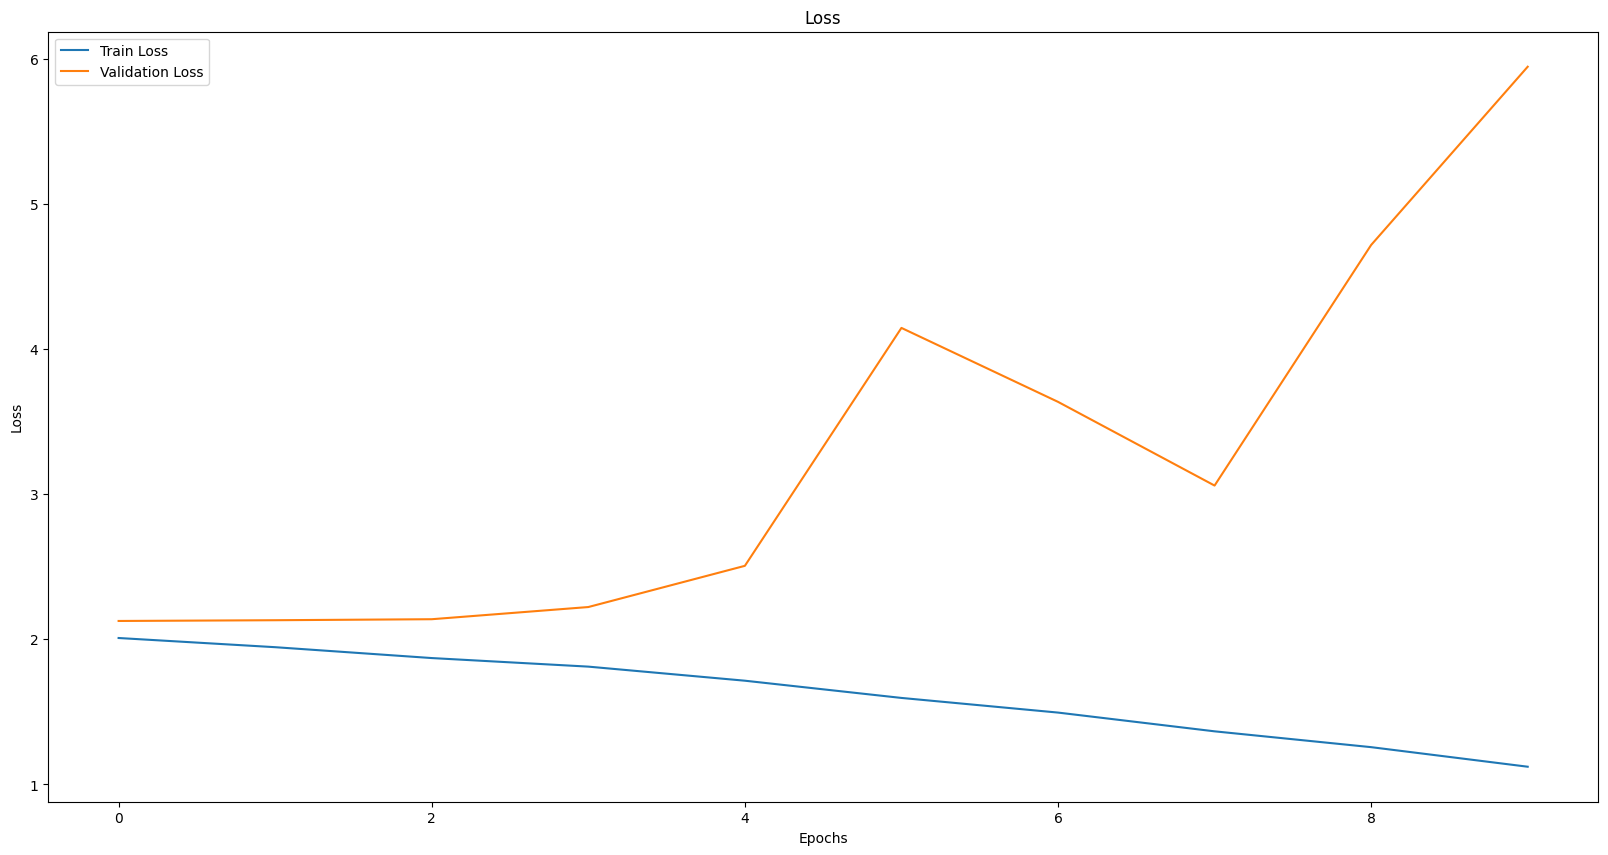

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities for the test set
y_pred_probs = model.predict(x_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot training & validation loss
plt.figure(figsize=(20, 10))
plt.title('Loss')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


Micro-Averaged ROC AUC: 0.5103395061728395
No Skill: ROC AUC=0.500
Model: ROC AUC=0.510


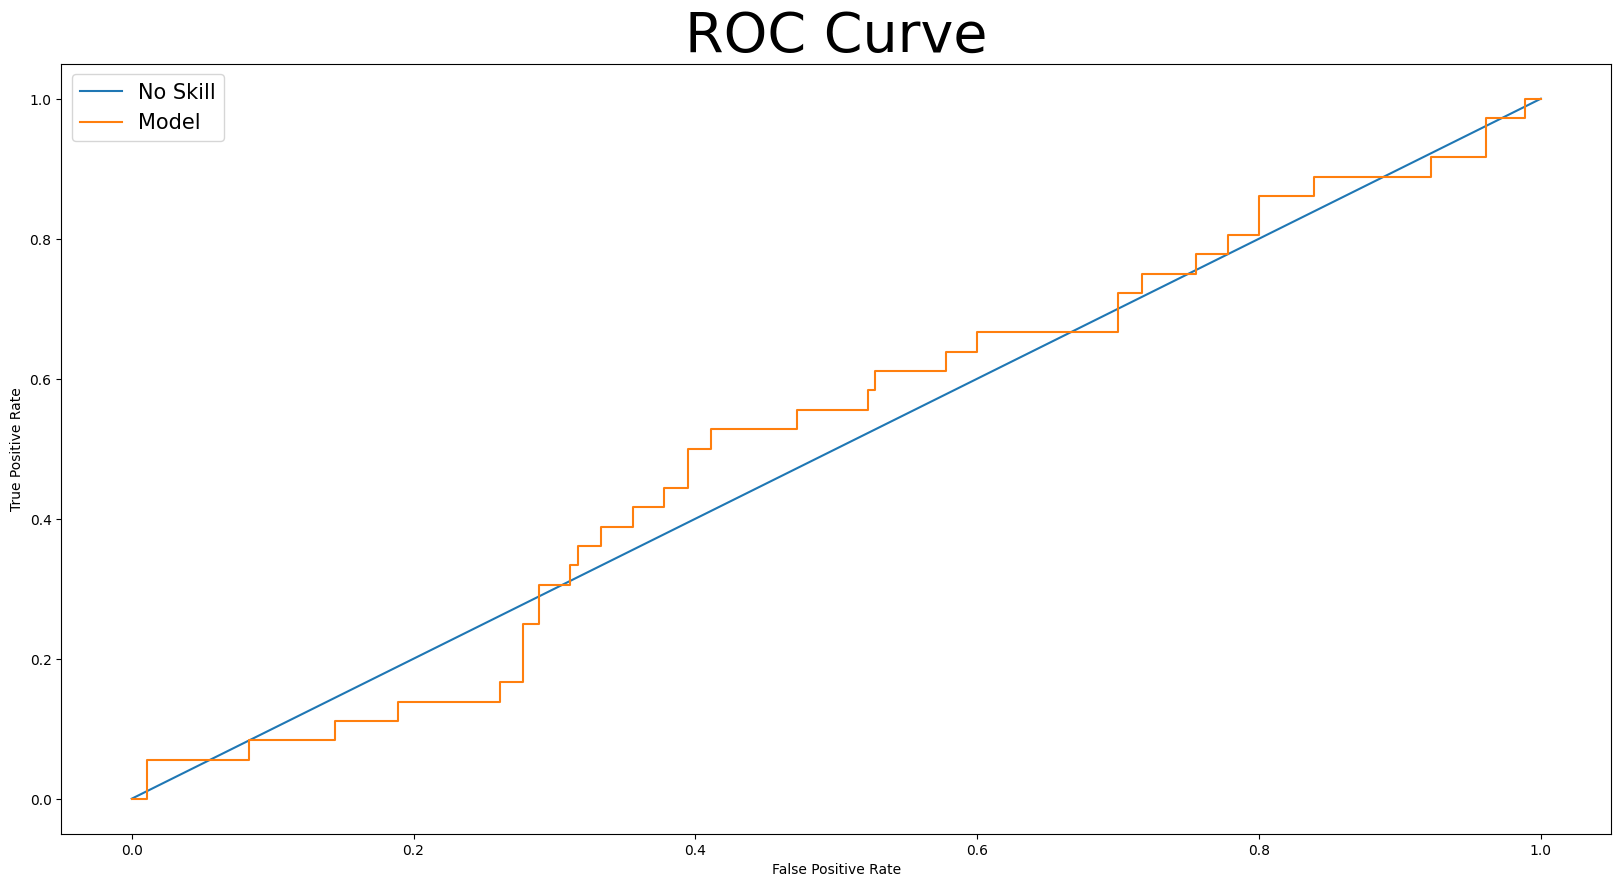

In [14]:
import sklearn
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Model predictions on the test set
predict = model.predict(x_test)

# AUC (micro-average for multi-class)
auc = roc_auc_score(y_test, predict, multi_class='ovr', average='micro')
print("Micro-Averaged ROC AUC:", auc)

# Flatten for binary-style ROC plotting (micro-average)
y_test_flat = np.reshape(y_test, (y_test.size))
predict_flat = np.reshape(predict, (predict.size))

# Baseline "No Skill" predictions (all zeros)
ns_probs = [0 for _ in range(len(y_test_flat))]

# Calculate AUC scores
ns_auc = roc_auc_score(y_test_flat, ns_probs)
lr_auc = roc_auc_score(y_test_flat, predict_flat)

# Summarize scores
print('No Skill: ROC AUC=%.3f' % ns_auc)
print('Model: ROC AUC=%.3f' % lr_auc)

# Calculate ROC curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_flat, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_flat, predict_flat)

# Plot the ROC curve
plt.figure(figsize=(20, 10))
plt.title("ROC Curve", fontsize=40)
plt.plot(ns_fpr, ns_tpr, label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.rcParams["font.size"] = 15
plt.legend()
plt.show()


In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # Create a model mapping the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Create a model mapping the activations to the final predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Compute gradient of top predicted class w.r.t. last conv layer activations
    with tf.GradientTape() as tape:
        last_conv_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_output)
        preds = classifier_model(last_conv_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Gradients & importance weights
    grads = tape.gradient(top_class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight each channel in feature map
    last_conv_output = last_conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_output[:, :, i] *= pooled_grads[i]

    # Compute heatmap & normalize
    heatmap = np.mean(last_conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    return heatmap

# Function to display Grad-CAM result over original image
def display_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay heatmap on image
    superimposed_img = heatmap_color * alpha + cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    superimposed_img = np.uint8(superimposed_img)

    # Show results
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(superimposed_img[..., ::-1])
    plt.axis('off')
    plt.show()

# Example usage:
# Assuming your last conv layer is named "top_conv" (EfficientNet default)
# and classifier layers are ["top_bn", "top_activation", "global_average_pooling2d", "predictions"]
# single_img = x_test[0][np.newaxis, ...]  # shape (1, 256, 256, 1)
# heatmap = make_gradcam_heatmap(single_img, model, "top_conv", ["top_bn", "top_activation", "global_average_pooling2d", "predictions"])
# display_gradcam((x_test[0] * 255).astype("uint8"), heatmap)


In [4]:
import matplotlib.pyplot as plt

# Use first test image as img_array (shape: (1, 256, 256, 1))
img_array = np.expand_dims(x_test[0], axis=0)

plt.figure(figsize=(20, 10))
plt.title("Original Image", fontsize=40)
plt.imshow(img_array[0, :, :, 0], cmap="gray")
plt.axis('off')
plt.show()


NameError: name 'np' is not defined